# Descripción del proyecto

En este proyecto vamos a trabajar con dos archivos uno que contienen fotografias de personas con diferentes edades y otro que  contiene las caracteristicas a esas fotografias, mediante la visión artificial entrenaremos un modelo que busque predecir la edad de las personas como una herramienta útil para diversas aplicaciones y servicios.

# Descripción de los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 


- El archivo `labels.csv` contiene dos columnas: 
  - `'file_name'` 
  - `'real_age'` 

# Inicialización

In [13]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from PIL import Image
import os

In [14]:
labels = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/faces/labels.csv')

# EDA

In [15]:
#tamaño del conjunto de datos
labels.shape

(7591, 2)

In [16]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [17]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [18]:
labels.duplicated().sum()

0

In [19]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

## Visualización de la distribución de las edades

(array([363., 266., 186., 525., 714., 746., 987., 784., 569., 542., 378.,
        321., 376., 181., 207.,  99.,  87.,  91.,  40.,  48.,  19.,  24.,
         26.,  10.,   2.]),
 array([  1.  ,   4.96,   8.92,  12.88,  16.84,  20.8 ,  24.76,  28.72,
         32.68,  36.64,  40.6 ,  44.56,  48.52,  52.48,  56.44,  60.4 ,
         64.36,  68.32,  72.28,  76.24,  80.2 ,  84.16,  88.12,  92.08,
         96.04, 100.  ]),
 <BarContainer object of 25 artists>)

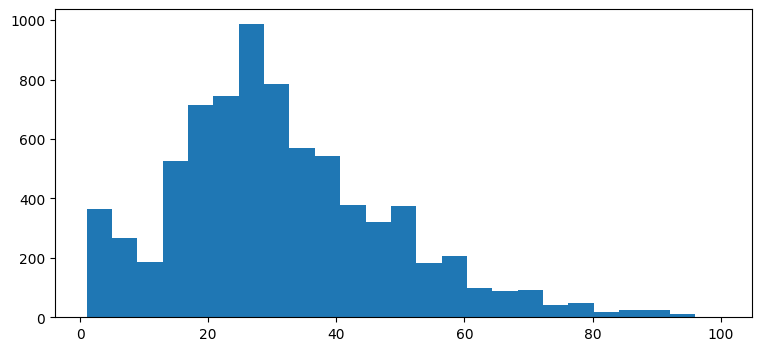

In [20]:
plt.figure(figsize=(9, 4))
plt.hist(labels['real_age'], bins=25)

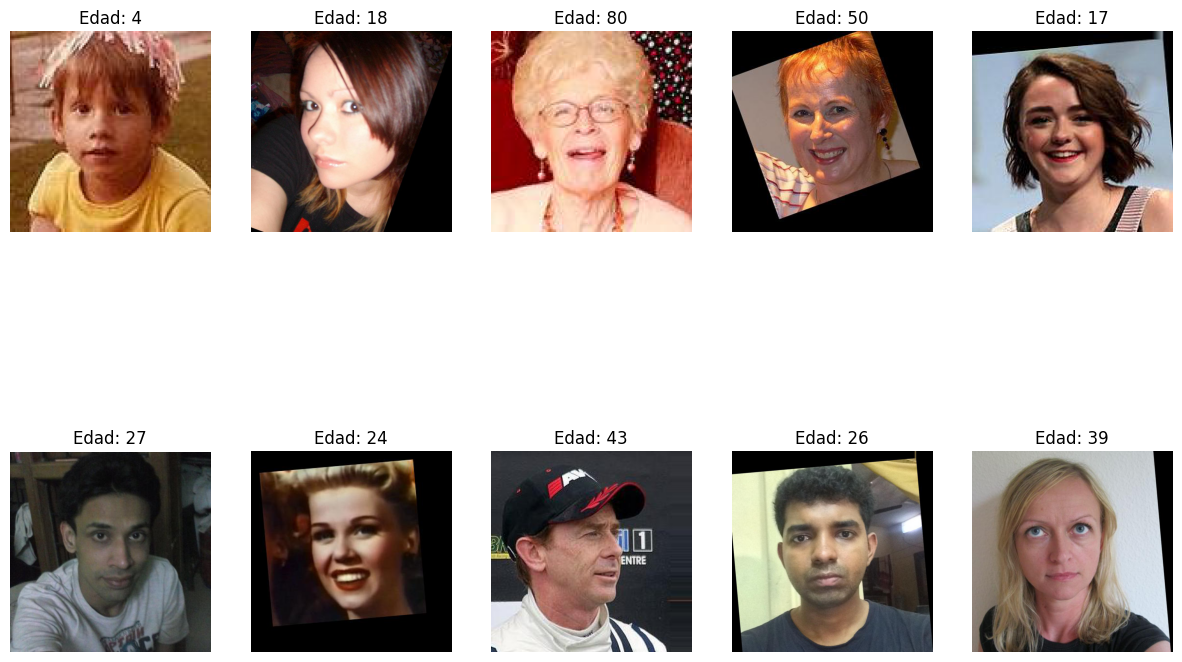

In [21]:
# Mostrar algunas imágenes representativas de diferentes edades
ages_sample = labels['real_age'].unique()[:10]  # Tomar una muestra de 10 edades diferentes

plt.figure(figsize=(15, 10))
for i, age in enumerate(ages_sample):
    # Obtener la primera imagen correspondiente a cada edad en la muestra
    image_name = labels[labels['real_age'] == age].iloc[0]['file_name']
    image_path = os.path.join('/datasets/faces/final_files/', image_name)
    
 # Abrir y mostrar la imagen
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Edad: {age}')
    plt.axis('off')

plt.show()
    

### Conclusiones EDA

Tenemos un comjunto de datos con 7591 filas y 2 columnas sin valores nulos ni duplicados, podemos ver en el histograma que los datos se cocentran más en el rango de edades del 20 a 31 años y el promedio de los valores en 31 años!!tambien hicimos una muestra de 10 fotos con sus respectivas edades.

# Modelado

In [22]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

Definiremos las funciones necesarias para entrenar nuestro modelo en la plataforma GPU y crearemos un solo script que las contenga todas junto con la sección de inicialización.

Dado que el número de archivos de imágenes es bastante elevado para evitar leerlos todos a la vez y consumir muchos recursos computacionales crearemos un generador con ImageDataGenerator. 

In [23]:
def load_train(path):
    
       
    """
    Cargar la parte de entrenamiento del conjunto de datos desde la ruta.
    """  
    train_datagen = ImageDataGenerator(rescale=1/255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    return train_gen_flow

In [24]:
def load_test(path):
    
    """
    Cargar la parte de validación/prueba del conjunto de datos desde la ruta
    """
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    return test_gen_flow

In [1]:
def create_model(input_shape=(224,224,3)):
    
    """
    Definir el modelo
    """
    backbone = ResNet50(input_shape= input_shape, weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu')) 
    model.add(Dense(1))

    optimizer = 'adam'
    model.compile(
        loss='mse', optimizer=optimizer, metrics=['mae']
    )
    

    return model

In [26]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrenar el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size = batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

Aquí podríamos agregar al inicio la línea  **'%%time'**  para observar el tiempo que demora esta ejecución.

# Preparación del script para ejecutarlo en la plataforma GPU

Una vez que definimos las funciones necesarias, podemos redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

**Nota:** el script debe incluir también la sección de inicialización. 

In [ ]:
# script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

El resultado de la plataforma GPU como una celda Markdown.

Train for 238 steps, validate for 238 steps

- Epoch 1/20
  238/238 - 94s - loss: 206.3036 - mae: 10.9097 - val_loss: 294.9560 - val_mae: 13.4941

- Epoch 2/20
  238/238 - 73s - loss: 135.4245 - mae: 8.9065 - val_loss: 336.4345 - val_mae: 13.6013

- Epoch 3/20
  238/238 - 73s - loss: 101.7726 - mae: 7.7838 - val_loss: 312.4699 - val_mae: 13.1479

- Epoch 4/20
  238/238 - 73s - loss: 80.6980 - mae: 6.9216 - val_loss: 116.6314 - val_mae: 8.3452

- Epoch 5/20
  238/238 - 73s - loss: 61.0772 - mae: 6.0389 - val_loss: 97.2043 - val_mae: 7.5011

- Epoch 6/20
  238/238 - 73s - loss: 47.4577 - mae: 5.3392 - val_loss: 81.3890 - val_mae: 7.0531

- Epoch 7/20
  238/238 - 73s - loss: 35.7029 - mae: 4.6355 - val_loss: 72.1202 - val_mae: 6.6095

- Epoch 8/20
  238/238 - 73s - loss: 27.2286 - mae: 4.0524 - val_loss: 111.6425 - val_mae: 8.6639

- Epoch 9/20
  238/238 - 73s - loss: 20.7493 - mae: 3.5432 - val_loss: 21.4818 - val_mae: 3.4643

- Epoch 10/20
  238/238 - 73s - loss: 16.5538 - mae: 3.1391 - val_loss: 19.7562 - val_mae: 3.3593

- Epoch 11/20
  238/238 - 73s - loss: 15.9734 - mae: 3.0754 - val_loss: 16.0579 - val_mae: 3.0354

- Epoch 12/20
  238/238 - 73s - loss: 13.0680 - mae: 2.7654 - val_loss: 53.2398 - val_mae: 5.9009

- Epoch 13/20
  238/238 - 73s - loss: 12.1544 - mae: 2.6758 - val_loss: 56.4466 - val_mae: 5.9875

- Epoch 14/20
  238/238 - 73s - loss: 11.8743 - mae: 2.6439 - val_loss: 23.6842 - val_mae: 3.6128

- Epoch 15/20
  238/238 - 73s - loss: 12.5846 - mae: 2.7206 - val_loss: 21.2211 - val_mae: 3.5115

- Epoch 16/20
  238/238 - 73s - loss: 13.2261 - mae: 2.7931 - val_loss: 37.6242 - val_mae: 4.5908

- Epoch 17/20
  238/238 - 73s - loss: 12.5294 - mae: 2.7392 - val_loss: 32.1232 - val_mae: 4.3332

- Epoch 18/20
  238/238 - 73s - loss: 12.4565 - mae: 2.7052 - val_loss: 15.1000 - val_mae: 3.0047

- Epoch 19/20
  238/238 - 73s - loss: 12.8764 - mae: 2.7695 - val_loss: 18.7669 - val_mae: 3.3323

- Epoch 20/20
  238/238 - 73s - loss: 11.5359 - mae: 2.5963 - val_loss: 15.7405 - val_mae: 3.0223


**238/238 - 36s - loss: 15.7405 - mae: 3.0223
Test MAE: 3.0223**

## Conclusiones

Parece que nuestro modelo está entrenando bien! La métrica MAE (Mean Absolute Error) en el conjunto de prueba es de 3.0223, lo cual indica que en promedio, las predicciones del modelo están a 3.0223 unidades de los valores reales.

Estos enfoques pueden ayudarnos a crear una solución efectiva para predecir la edad y verificar si alguien es mayor de 18 años, proporcionandonos una herramienta útil para diversas aplicaciones y servicios.

Como por ejemplo:
- Autenticación en Línea: comprobación de edad, para compras en linea!!


- Control de Acceso: aplicarlo en áreas donde se necesite verificar la edad, como en eventos realizados por el cliente ya sea un  festival anual de bebidas alcoholicas..(por ejemplo)